In [11]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

import numpy as np
from scipy.linalg import lu, inv

def gaussWithTruncation(A,B):
    """
    Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
    """
    # LU decomposition with pivot
    p, l, u = lu(A, permute_l=False)
    
    # forward substitution to solve for Ly = B
    y = np.zeros(B.size, dtype=complex)
    for m, b in enumerate((p.T @ B).flatten()):
        y[m] = b
        # skip for loop if m == 0
        if m:
            for n in range(m):
                y[m] -= y[n] * l[m,n]
        y[m] /= l[m, m]

    # truncation for IPR
    c = np.abs(y) < 100 * np.finfo(float).eps
    y[c] = 0

    # backward substitution to solve for y = Ux
    x = np.zeros(B.size, dtype=complex)
    lastidx = B.size - 1  # last index
    for midx in range(B.size):
        m = B.size - 1 - midx  # backwards index
        x[m] = y[m]
        if midx:
            for nidx in range(midx):
                n = B.size - 1  - nidx
                x[m] -= x[n] * u[m,n]
        x[m] /= u[m, m]
    return x

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi)**2 - np.abs(psi_ref)**2) / (np.abs(psi_ref)**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi)**2 - np.abs(psi_ref)**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

def multiply_along_axis(A, B, axis):
    return np.swapaxes(np.swapaxes(A, axis, -1) * B, -1, axis)


class PolynomialReconstructionScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.lam = 1
        self.W   = self.directW(self.shiftx(self.grid[0]), int(len(self.grid[0])/2), self.lam)
        self.inv = scipy.linalg.inv(self.W)
        self.counter = 0
        self.freq = 1000
        

    def getk(self, x): 
        N = int(len(x)/2)
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        #return np.pi * np.concatenate([np.arange(0, N + 1),-np.flip(np.arange(1, N))]) / ((b - a)/2)
        return np.pi * np.concatenate([np.arange(0, N+1),-np.flip(np.arange(1, N))]) / ((b - a)/2)
    
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)
        #else:
        #    self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
        #    self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        N           = len(psi)
        
        #Boundary for finite difference stencils
        Coeff1 = 1j * 1/2  * dt * self.eta


        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        k               = sd.computeK(self.psi, dx, sd.PERIODIC)
        

        fhat            = scipy.fft.fft(self.psi)


        if 0:
            g = gaussWithTruncation(self.W, fhat* np.exp(-Coeff1 * k**2))
            self.psi         = self.reconstruct(g, self.lam, self.shiftx(x))

        elif 0:
            g1 = gaussWithTruncation(self.W, fhat * np.exp(-Coeff1 * k**2))
            g2 = gaussWithTruncation(self.W, fhat                        )
            p1 = self.reconstruct(g1, self.lam, self.shiftx(x))
            p2 = self.reconstruct(g2, self.lam, self.shiftx(x))
            self.psi         = self.psi + (p1 - p2) 

        elif 1:
            g1 = gaussWithTruncation(self.W, fhat * (np.exp(-Coeff1 * k**2) - 1))
            p1 = self.reconstruct(g1, self.lam, self.shiftx(x))
            self.psi         = self.psi + p1

        elif 0:

            W = np.zeros((N, N), dtype=complex)
            
            for l in range(N):
                W[:, l] = scipy.fft.fft(self.C(self.shiftx(x), self.lam, l)) * np.exp(Coeff1 * k**2)

            g = gaussWithTruncation(W, fhat)

            self.psi         = self.reconstruct(g, self.lam, self.shiftx(x))
        else: 
            self.psi = scipy.fft.ifft(np.exp(-Coeff1 * k**2) * fhat)


        self.t += dt

        if self.counter % self.freq == 0:
            plt.title(f"relative error at counter {self.counter}") 
            plt.yscale("log") 
            plt.plot(self.computeRelErrorArray())
            plt.show()
            
        self.counter += 1


    def getName(self):
        return "ipr dft scheme"
 

    def C(self, x, lam, N): 
        return scipy.special.eval_chebyt(N, x)

    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.C(x, lam, l))

        return W 

    def reconstruct(self, g, lam, x): 
        n = len(x)
        f = np.zeros(x.shape, dtype=complex)
        for l, coeff in enumerate(g):
            f += coeff * self.C(x, lam, l)

        return f

    def shiftx(self, x):
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        return  (x - (a + b)/2)/ ((b - a)/2)


[array([-0.25806452, -0.22580645, -0.19354839, -0.16129032, -0.12903226,
       -0.09677419, -0.06451613, -0.03225806,  0.        ,  0.03225806,
        0.06451613,  0.09677419,  0.12903226,  0.16129032,  0.19354839,
        0.22580645,  0.25806452,  0.29032258,  0.32258065,  0.35483871,
        0.38709677,  0.41935484,  0.4516129 ,  0.48387097,  0.51612903,
        0.5483871 ,  0.58064516,  0.61290323,  0.64516129,  0.67741935,
        0.70967742,  0.74193548,  0.77419355,  0.80645161,  0.83870968,
        0.87096774,  0.90322581,  0.93548387,  0.96774194,  1.        ,
        1.03225806,  1.06451613,  1.09677419,  1.12903226,  1.16129032,
        1.19354839,  1.22580645,  1.25806452])]


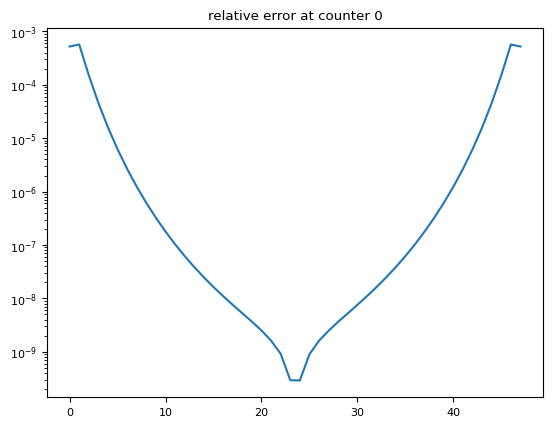

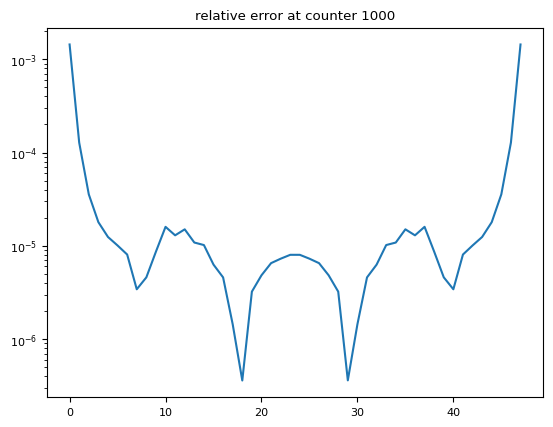

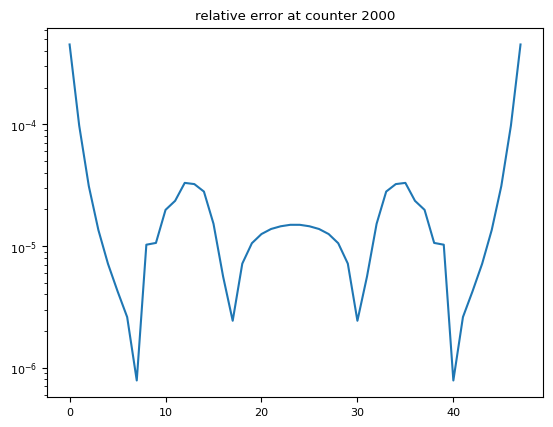

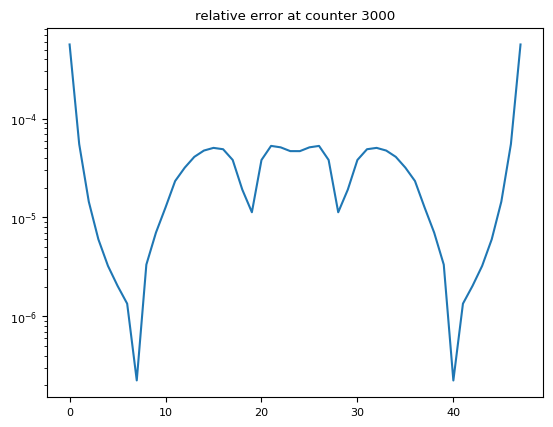

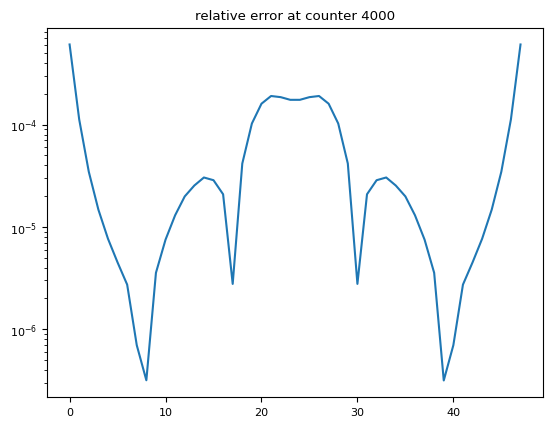

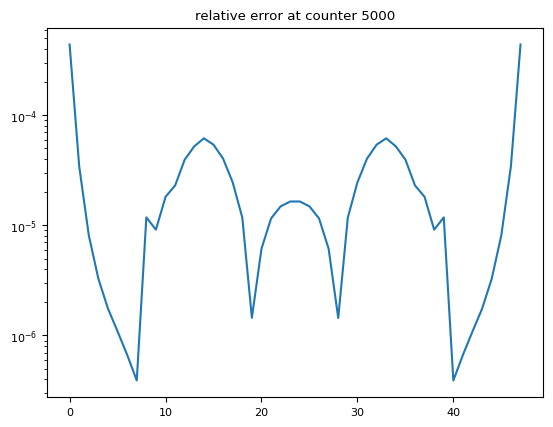

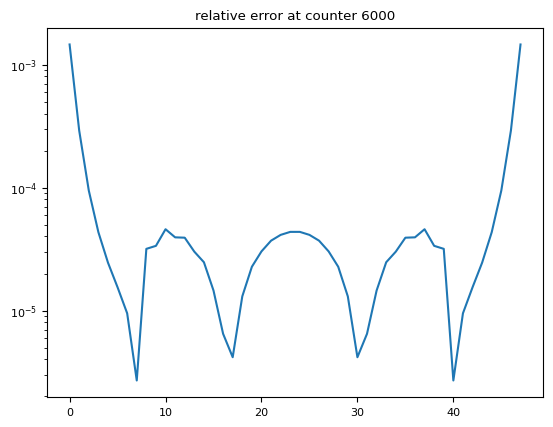

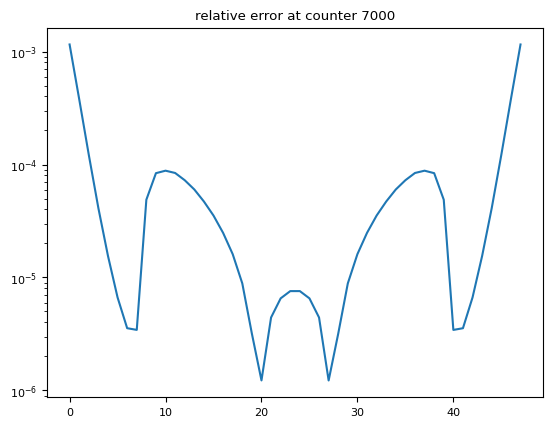

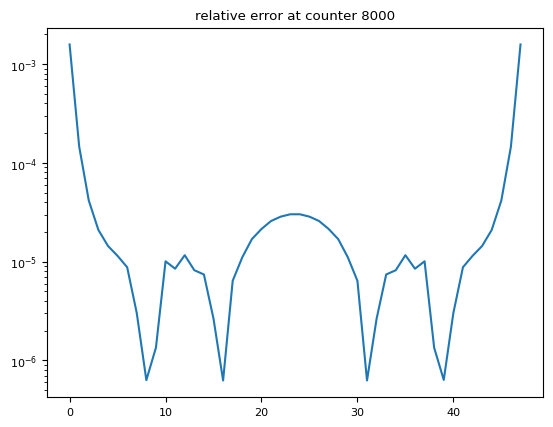

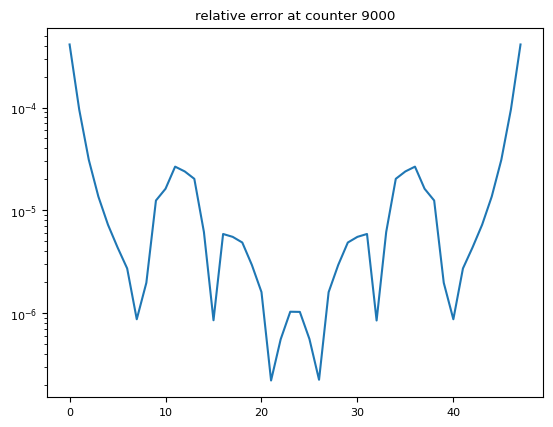

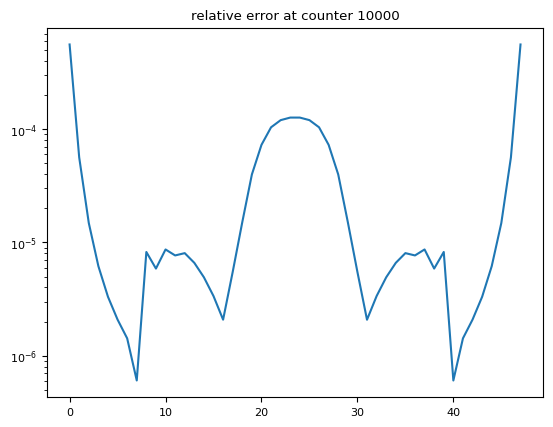

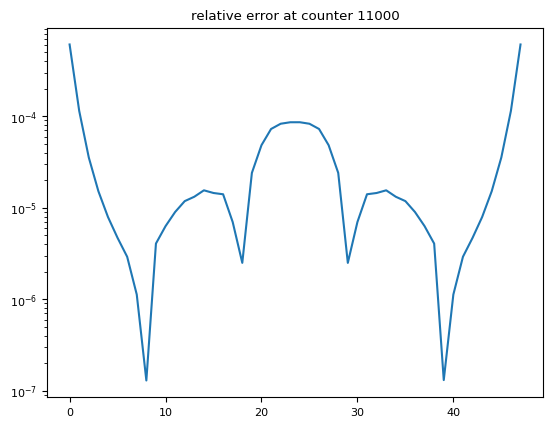

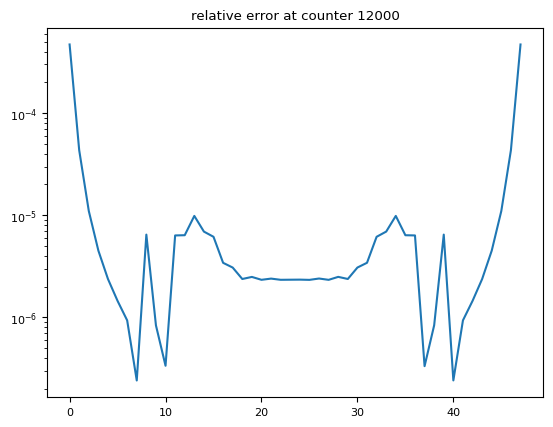

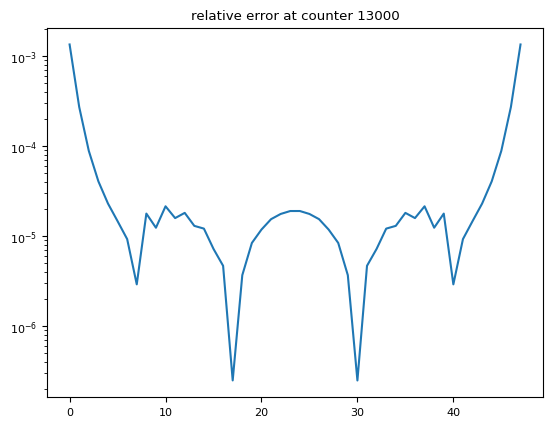

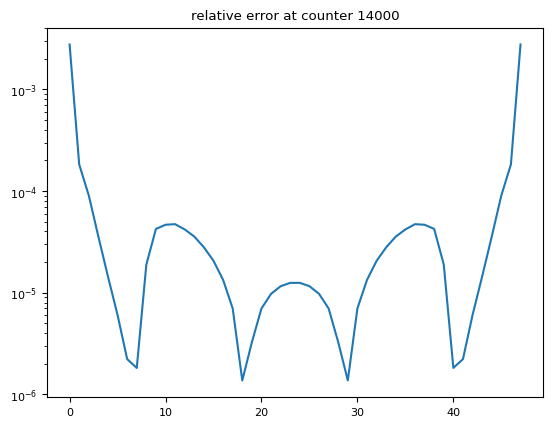

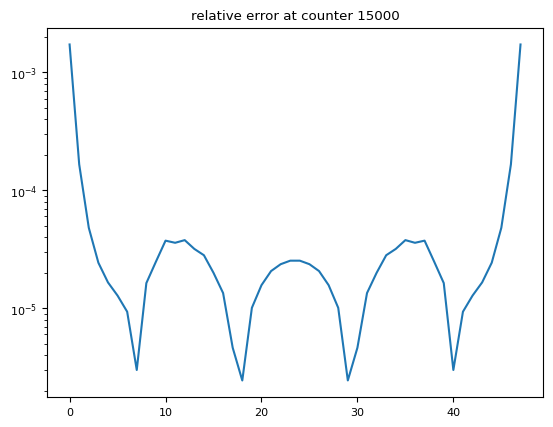

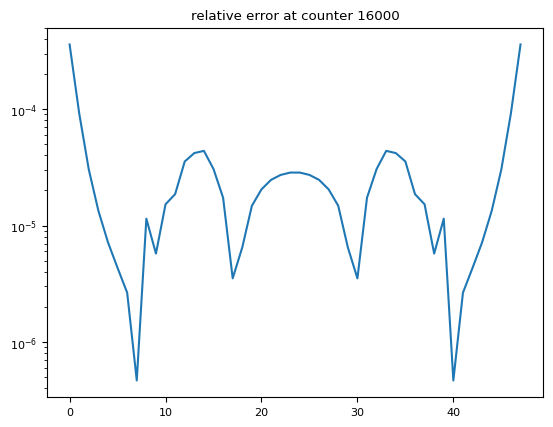

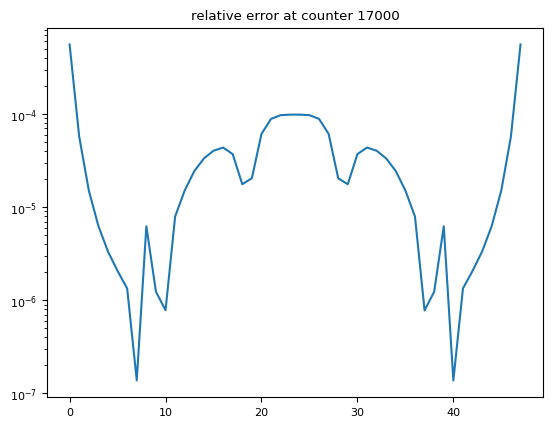

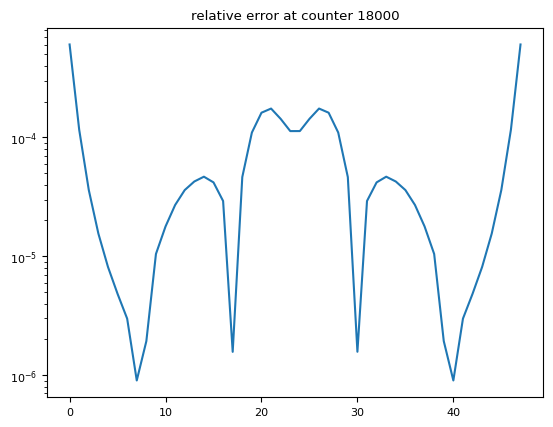

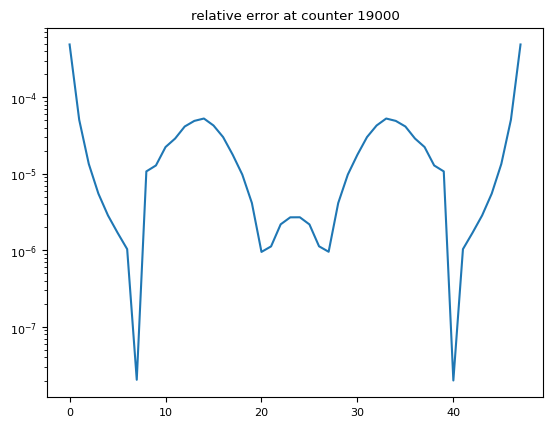

Finished in 19221 time steps


(9.670781734654972e-06, 1.257311333117685e-05)

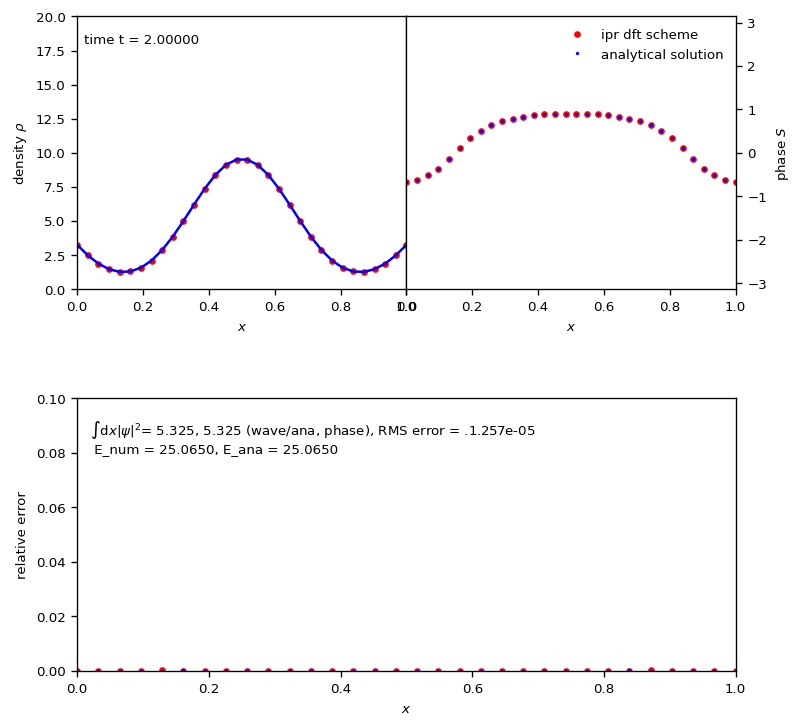

In [13]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 


c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True
c["C_parabolic"]                = 0.1
c["printGrid"]                  = False
scheme = PolynomialReconstructionScheme(c, periodic1DGaussian) 
print(scheme.grid)
scheme.run(2)
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

### Lesson

What we learn from this is that exp(-k^2) does destroy the convergence of the IPR and any method that wants to use it directly is bound to fail. 

### Test with subregions (does not help)

In [84]:

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    #def getUpdatedFields(self, t, dt, old_psi):
    def step(self, dt):
        #self.psi = np.copy(old_psi)

        print_grid = self.print_grid
        
        if 0:
            plt.title("Before boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        if 0:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)

            if print_grid:
                print(f"Writing BC to {self.boundary}")


            #Set outer ghost zone
            self.psi[self.boundary] = f[self.boundary]

        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("After boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        self.t += dt
        #return self.psi# - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])


/tmp/ipykernel_5096/3017261422.py:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


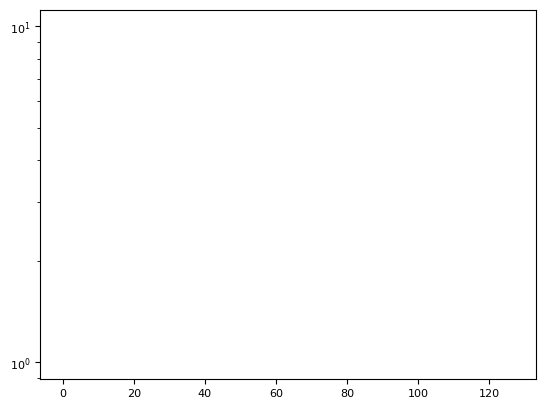

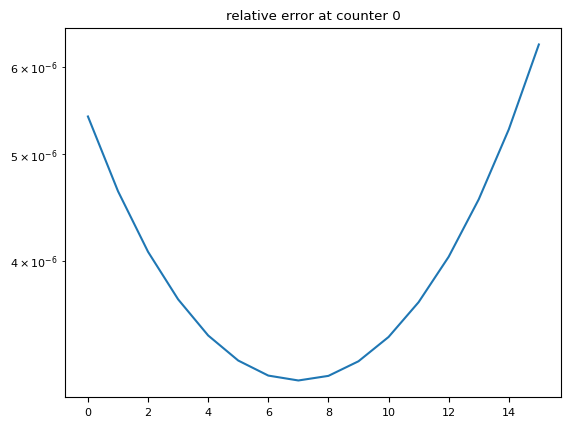

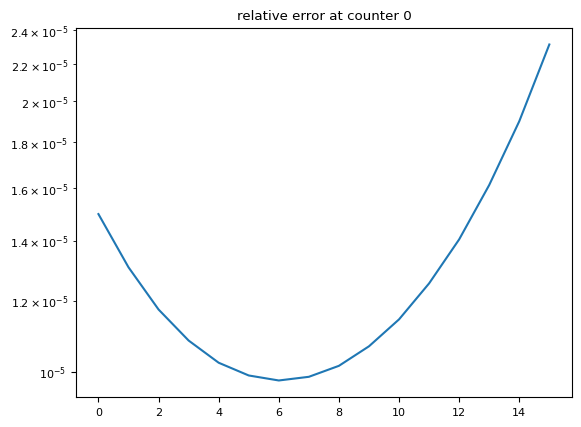

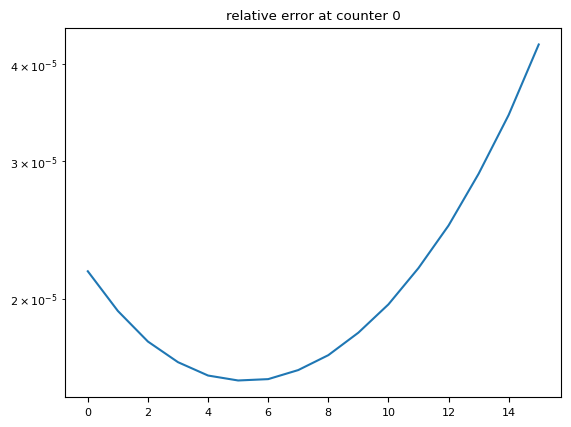

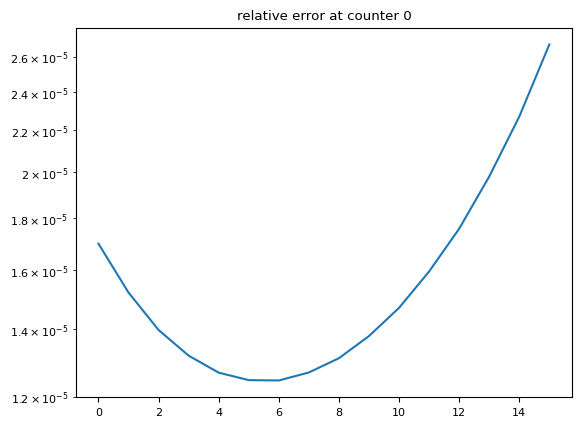

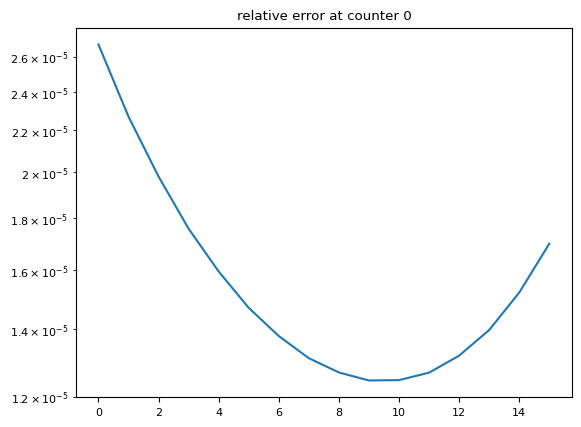

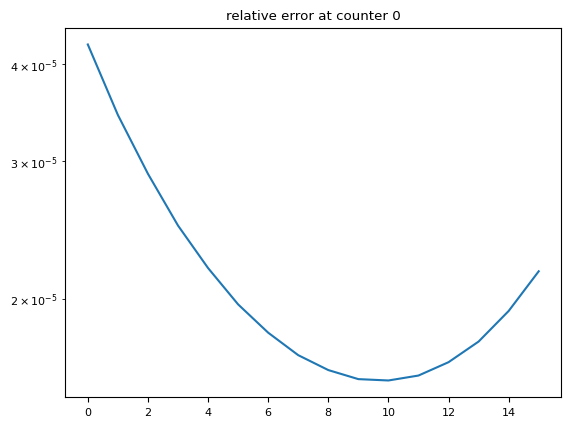

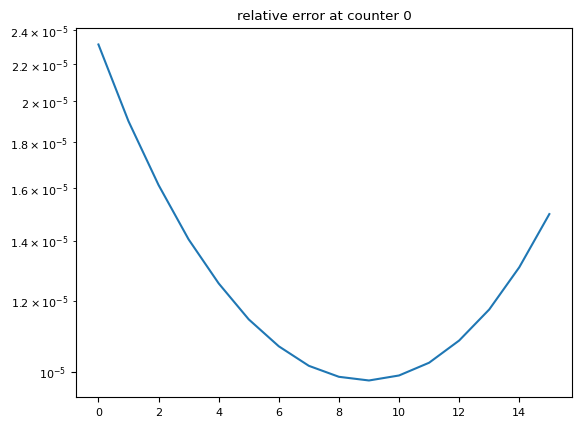

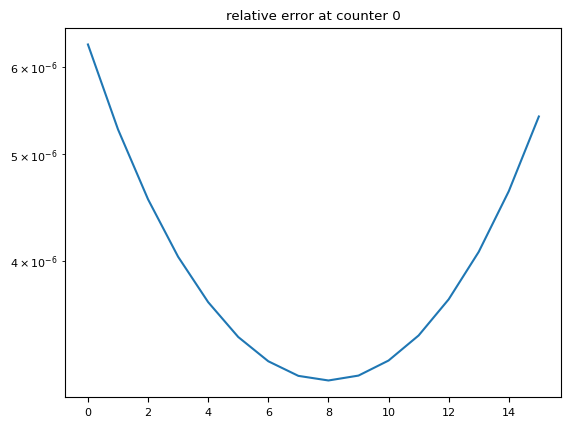

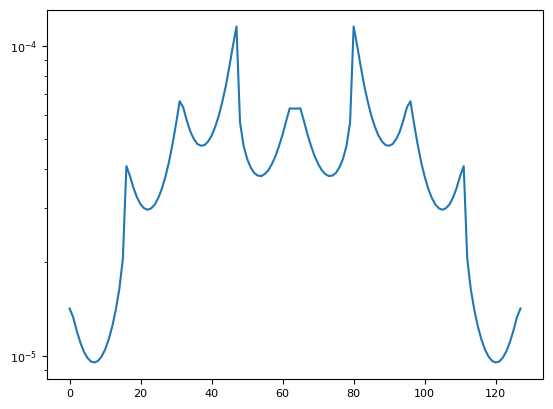

(2.9799772647471994e-05, 2.1674328036888736e-05)

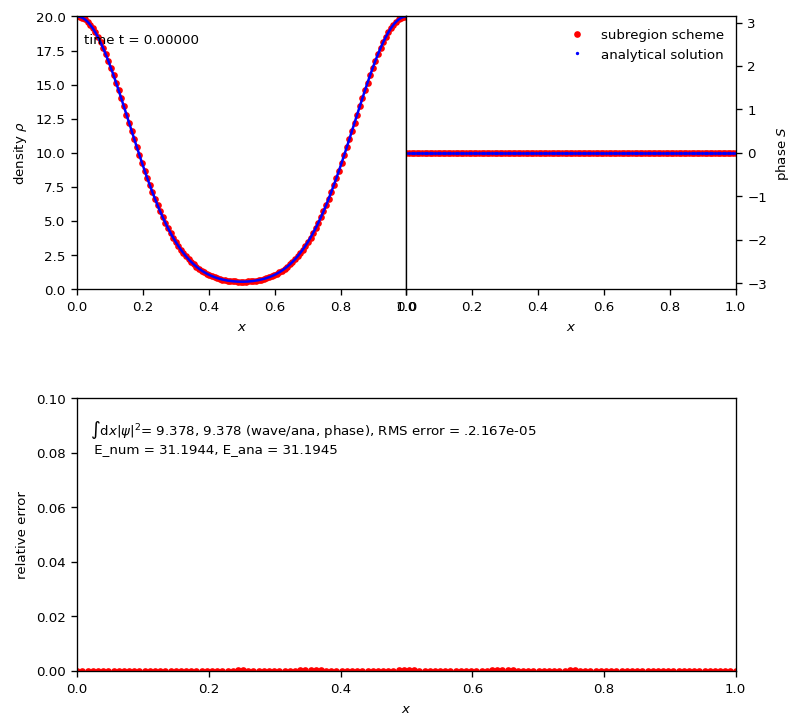

In [344]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2
c["resolution"]                 = 128
c["patchSize"]                  = 16
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True
c["C_parabolic"]                = 0.05
c["printGrid"]                  = False
scheme = SubregionScheme(c, periodic1DGaussian, PolynomialReconstructionScheme) 
plt.plot(scheme.computeRelErrorArray())
plt.yscale("log")
plt.show() 
scheme.step(1e-6) 
scheme.step(1e-6) 
plt.plot(scheme.computeRelErrorArray())
plt.yscale("log")
plt.show()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

## Solve everything in Cheby basis

The idea is that we use the IPR approximation to evolve the polynomial instead of the wave function

In [62]:

def gaussWithTruncation(A,B):
    """
    Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
    """
    # LU decomposition with pivot
    p, l, u = lu(A, permute_l=False)
    
    # forward substitution to solve for Ly = B
    y = np.zeros(B.size, dtype=complex)
    for m, b in enumerate((p.T @ B).flatten()):
        y[m] = b
        # skip for loop if m == 0
        if m:
            for n in range(m):
                y[m] -= y[n] * l[m,n]
        y[m] /= l[m, m]

    # truncation for IPR
    c = np.abs(y) < 50 * np.finfo(float).eps
    y[c] = 0

    # backward substitution to solve for y = Ux
    x = np.zeros(B.size, dtype=complex)
    lastidx = B.size - 1  # last index
    for midx in range(B.size):
        m = B.size - 1 - midx  # backwards index
        x[m] = y[m]
        if midx:
            for nidx in range(midx):
                n = B.size - 1  - nidx
                x[m] -= x[n] * u[m,n]
        x[m] /= u[m, m]
    return x


class IPRChebyScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.lam     = 50
        self.W       = self.directW(self.shiftx(self.grid[0]), int(len(self.grid[0])/2), self.lam)
        self.inv     = scipy.linalg.inv(self.W)
        self.counter = 0
        self.freq    = 20
        

    def getk(self, x): 
        N = int(len(x)/2)
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        #return np.pi * np.concatenate([np.arange(0, N + 1),-np.flip(np.arange(1, N))]) / ((b - a)/2)
        return np.pi * np.concatenate([np.arange(0, N+1),-np.flip(np.arange(1, N))]) / ((b - a)/2)
    
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)
        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("relative errors after BC") 
            plt.yscale("log") 
            plt.plot(scheme.computeRelErrorArray())
            plt.show()
        
        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        N           = len(psi)
        
        #Boundary for finite difference stencils
        Coeff1          = 1j * 1/2  * dt * self.eta

        p = self.psi

        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        fhat           = scipy.fft.fft(p)
        g              = gaussWithTruncation(self.W, fhat)

        inh            = self.reconstruct(g, self.lam)

        if 0:
            a  = x[0]
            b  = x[-1] + dx 
            plt.title(f"Original: {np.mean(np.abs(inh(self.shiftx(x)) - p)):3.3e}")
            plt.plot(p.real) 
            plt.plot(inh          (self.shiftx(x)).real, label="rec r") 
            plt.plot(p.imag) 
            plt.plot(inh          (self.shiftx(x)).real, label="rec i") 
            plt.legend()
            plt.show() 
            if 1:
                plt.plot("d1")
                plt.plot(p) 
                plt.plot(inh.deriv(1 )(self.shiftx(x))*(2/(b-a)), label="rec") 
                plt.legend()
                plt.show() 
                plt.plot("d10")
                plt.plot(p) 
                plt.plot(inh.deriv(6)(self.shiftx(x))*(2/(b-a))**6, label="rec") 
                plt.legend()
                plt.show() 
            

            y = [np.mean(np.abs(inh.deriv(i)(self.shiftx(x))*(2/(b-a))**i - p)) for i in range(20)]
            plt.title("Errors of derivatives")
            plt.yscale("log") 
            plt.plot(np.arange(20), y)
            plt.show() 

        
        #hom            = self.psi - inh(self.shiftx(x))
        #fhat           = scipy.fft.fft (hom) 
        #k              = self.getk(x)
        #exphom         = scipy.fft.ifft(fhat * np.exp(-Coeff1 * k**2))
        if 0:
            plt.title(f"hom, inh") 
            plt.plot(x, hom   , label="hom")
            plt.plot(x, inh(self.shiftx(x)), label="inh")
            plt.legend()
            plt.show() 
            plt.title(f"exphom, inh") 
            plt.plot(x, exphom   , label="hom")
            plt.plot(x, expinh, label="inh")
            plt.legend()
            plt.show() 

            plt.title("hom") 
            plt.plot(hom.real, label="real")
            plt.plot(hom.imag, label="imag")
            plt.legend()
            plt.show()
            plt.title("fhat") 
            plt.plot(fhat.real, label="real")
            plt.plot(fhat.imag, label="imag")
            plt.legend()
            plt.show()

            for i in range(1, 11):
                plt.title(f"{i}-th derivative of p") 
                dip = scipy.fft.ifft((1j * k)**i * fhat)
                plt.plot(dip.real, label="real")
                plt.plot(dip.imag, label="imag")
                plt.legend()
                plt.show()


        if 1:
            expf     = inh(self.shiftx(x)) 
        else:
            expf     = self.psi
            
        maxOrder = 12
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        
        for i in range(1, maxOrder + 1):
            TaylorCoeff = 1/np.math.factorial(i) * Coeff1**i
            expf       += TaylorCoeff * inh.deriv(2 * i)(self.shiftx(x)) / ((b - a)/2)**(2*i)

    
        self.psi     = expf# + exphom 
        self.t += dt

        self.counter += 1

        if self.counter % self.freq == 0:
            plt.title(f"relative errors after step {self.counter}") 
            plt.yscale("log") 
            plt.plot(scheme.computeRelErrorArray())
            plt.show() 



    def getName(self):
        return "ipr dft scheme"
 

    def C(self, x, lam, N): 
        return scipy.special.chebyt(N)(x)

    def poly(self, lam, N): 
        return scipy.special.chebyt(N)
    
    def reconstruct(self, g, lam): 
        f = np.poly1d([])
        #plt.title("G") 
        #plt.plot(np.arange(len(g)), g)
        #plt.show() 
        for l, coeff in enumerate(g):
            f += coeff * self.poly(lam, l)

        return f


    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.C(x, lam, l))

        return W 

    
    def shiftx(self, x):
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        return  (x - (a + b)/2)/ ((b - a)/2)


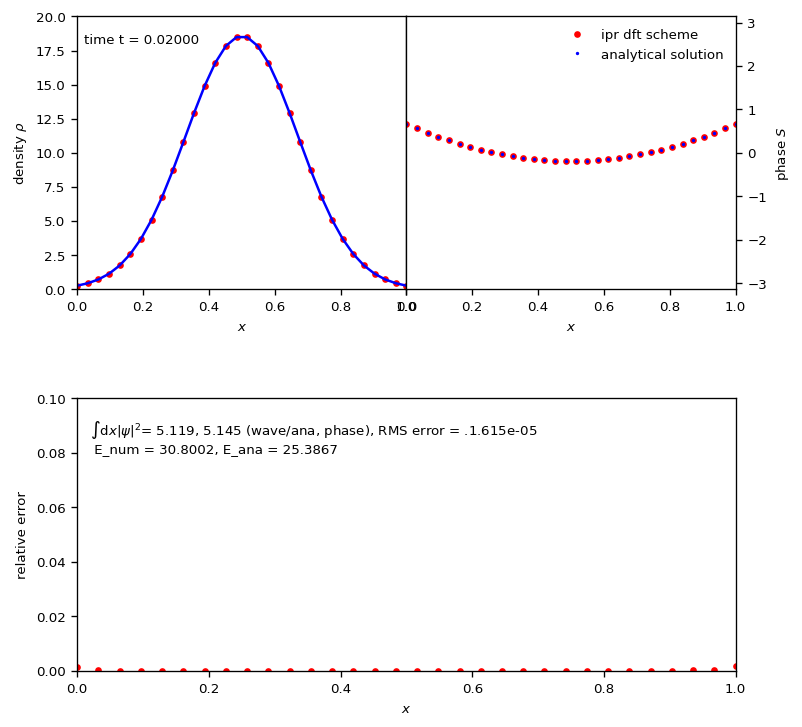

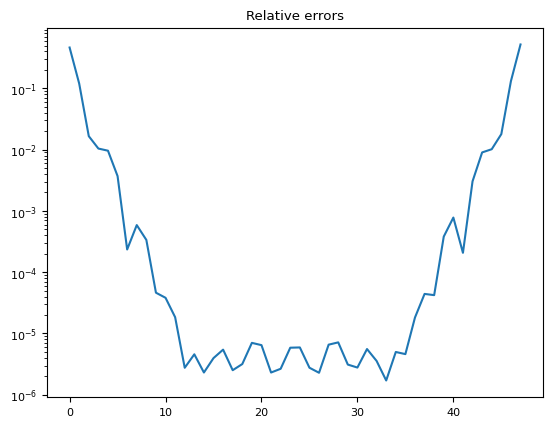

In [63]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 


c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True
c["printGrid"]                  = False
c["C_parabolic"]                = 0.01
scheme = IPRChebyScheme(c, periodic1DGaussian) 
scheme.step(0.02)
animation.drawFrame(scheme)
plt.show()
scheme.computeRelError(), scheme.computeRMSError()
plt.title("Relative errors") 
plt.yscale("log") 
plt.plot(scheme.computeAbsErrorArray())

Everything starts out very promising

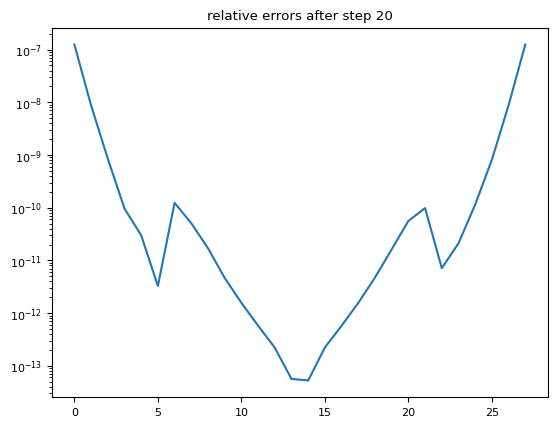

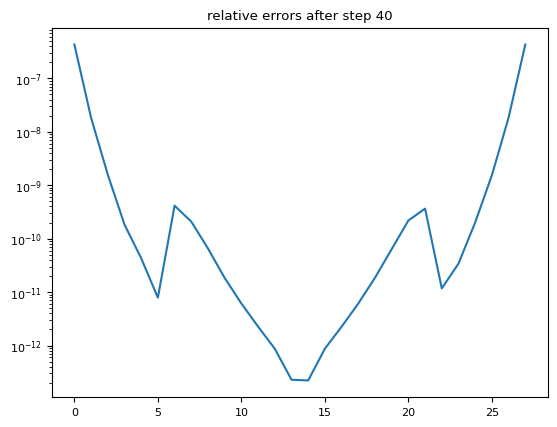

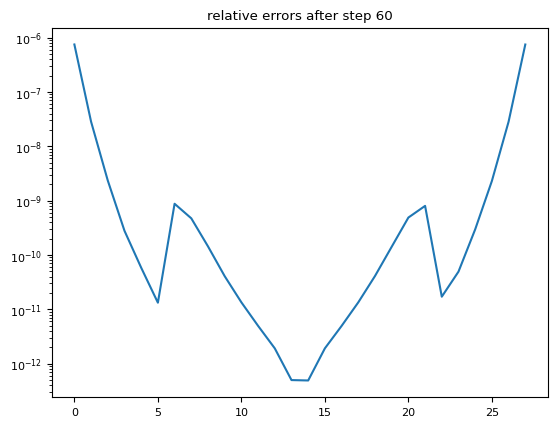

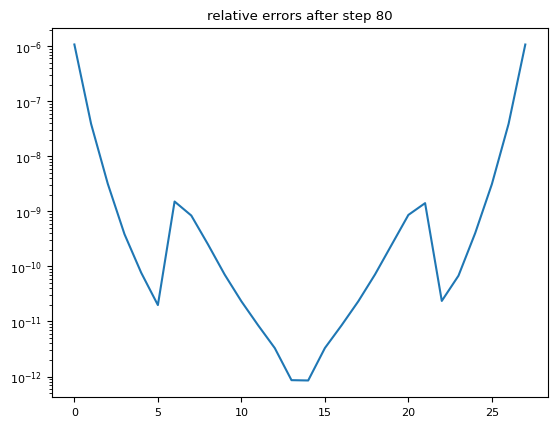

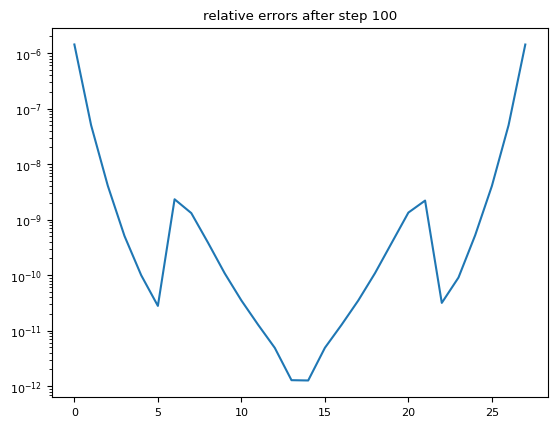

(6.560208774284598e-11, 1.578746336734823e-10)

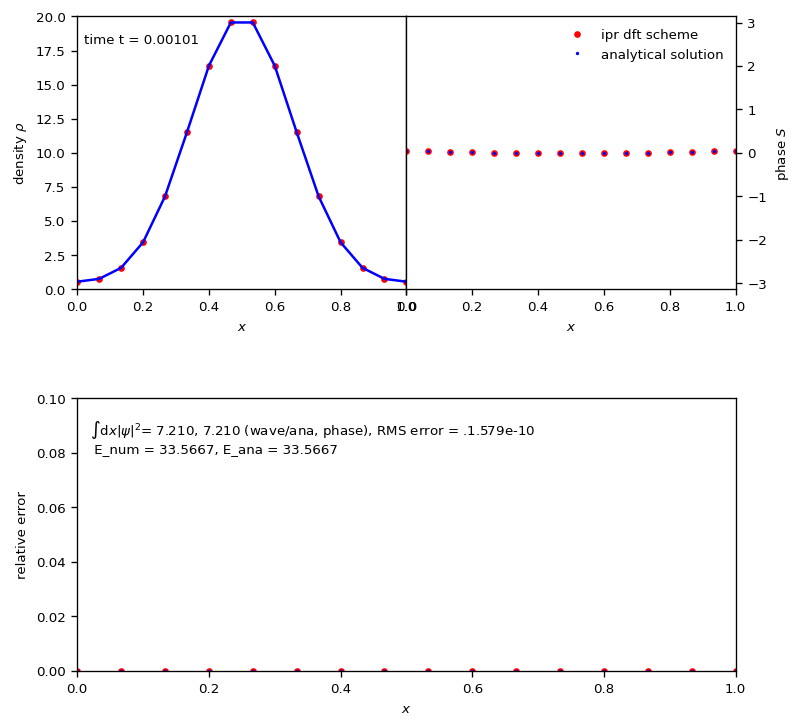

In [81]:
for i in range(100):
    scheme.step(1e-5)
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

/tmp/ipykernel_78562/3177424564.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


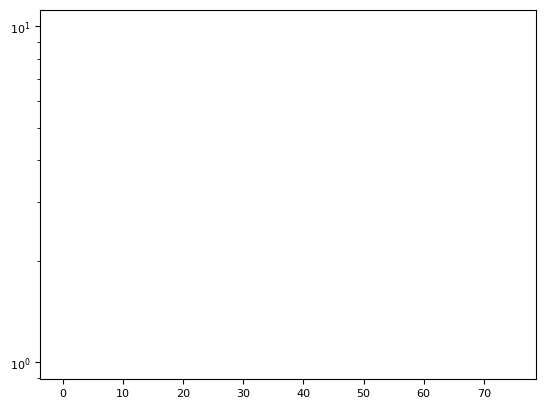

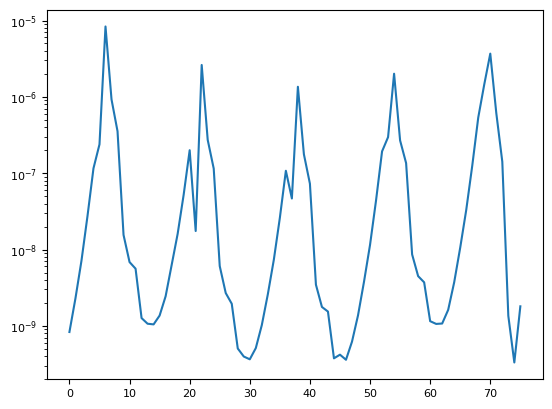

(1.3561286870779893e-06, 5.267130331429232e-07)

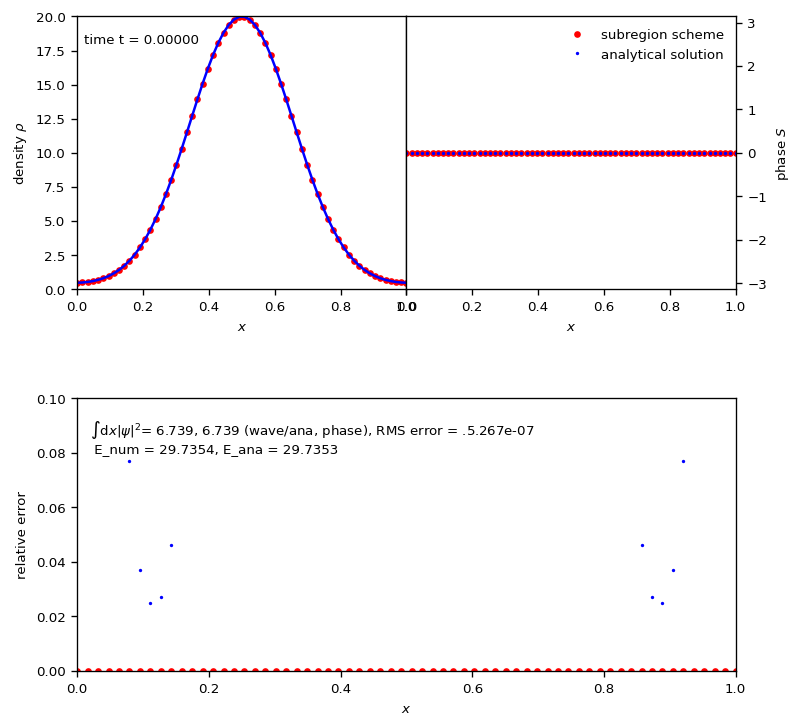

In [87]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1 + dx 
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2
c["resolution"]                 = 64
c["patchSize"]                  = 16
c["boundarySize"]               = 6
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True
c["C_parabolic"]                = 0.01
c["printGrid"]                  = False
scheme = SubregionScheme(c, periodic1DGaussian, IPRChebyScheme) 
plt.plot(scheme.computeRelErrorArray())
plt.yscale("log")
plt.show() 
scheme.step(1e-7) 
scheme.step(1e-7) 
plt.plot(scheme.computeRelErrorArray())
plt.yscale("log")
plt.show()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

Splitting into a homogeneous and an inhomogeneous solution does not work because the IPR has the highest errors at the boundary and does not enforce periodicity. 